In [2]:
import time 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor

import optuna
from xgboost import XGBClassifier, XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

np.random.seed(0)
torch.manual_seed(0)

d:\Skripsi\Location Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = 'data_preprocessed.csv'  
df = pd.read_csv(path)
print(df.shape)

(1984, 12)


In [4]:
df.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
1321,2024-10-23 07:24:12.080672200+00:00,41,3,DTE Staff,2,1,2454,1037,-200.0,-64.0,1,07:24:12.080672
76,2024-10-17 09:00:17.716274900+00:00,2,18,DTE Student,4,11,300,1567,-63.0,-200.0,0,09:00:17.716274
530,2024-10-17 10:31:15.907614500+00:00,30,6,DTE Staff,3,11,989,1202,-42.0,-200.0,1,10:31:15.907614
629,2024-10-17 10:43:18.522535900+00:00,37,11,DTE Student,4,11,1908,1037,-53.0,-200.0,1,10:43:18.522535
1503,2024-10-23 07:47:25.337724200+00:00,39,10,DTE Staff,3,11,2224,1037,-61.0,-200.0,1,07:47:25.337724


In [5]:
# Define the mapping dictionary for converting numeric BSSID back to normal
numeric_to_bssid = {
    1: '70:a7:41:dc:8e:55',  # AP Dosen (DTE Staff)
    2: '72:a7:41:9c:8e:55',  # AP Dosen (DTE Student)
    3: '70:a7:41:dc:77:cd',  # AP Digilab (DTE Staff)
    4: '72:a7:41:9c:77:cd'   # AP Digilab (DTE Student)
}

# Replace numeric BSSID identifiers in the 'bssid' column with their original format
df['bssid'] = df['bssid'].map(numeric_to_bssid)

# Print the updated DataFrame to check the conversion
df.sample(5)


,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric
1535,2024-10-23 07:51:33.349010300+00:00,39,18,DTE Staff,70:a7:41:dc:8e:55,1,2224,1037,-200.0,-70.0,1,07:51:33.349010
1118,2024-10-23 06:49:29.038629800+00:00,38,11,DTE Staff,72:a7:41:9c:8e:55,1,1908,1202,-200.0,-81.0,1,06:49:29.038629
727,2024-10-23 02:54:11.383374+00:00,11,19,DTE Student,72:a7:41:9c:77:cd,11,759,1368,-62.0,-200.0,0,02:54:11.383374
1969,2024-10-23 09:32:11.607256700+00:00,31,17,DTE Staff,70:a7:41:dc:77:cd,11,1219,1037,-43.0,-200.0,1,09:32:11.607256
1801,2024-10-23 09:11:44.641679+00:00,34,15,DTE Staff,70:a7:41:dc:77:cd,11,1449,1202,-48.0,-200.0,1,09:11:44.641679


In [6]:
ap_coordinates = {
    '70:a7:41:dc:77:cd': (870, 1122),  # AP Digilab (DTE Staff)
    '72:a7:41:9c:77:cd': (870, 1122),  # AP Digilab (DTE Student)
    '70:a7:41:dc:8e:55': (2314, 468),  # AP Dosen (DTE Staff)
    '72:a7:41:9c:8e:55': (2314, 468),  # AP Dosen (DTE Student)
}

# Map each row to the corresponding AP coordinates
def get_ap_coordinates(bssid):
    return ap_coordinates.get(bssid, (np.nan, np.nan))  # Default to NaN if BSSID not found

df['ap_x'], df['ap_y'] = zip(*df['bssid'].map(get_ap_coordinates))

# Step 2: Calculate the distance to the corresponding AP
df['distance'] = np.sqrt((df['xr'] - df['ap_x'])**2 + (df['yr'] - df['ap_y'])**2)

# Display the updated DataFrame
df.sample(5)

,time,reference_point,iteration,ssid,bssid,channel,xr,yr,rssi_ap_digilab,rssi_ap_dosen,relative_position,time_numeric,ap_x,ap_y,distance
1666,2024-10-23 08:55:36.647695400+00:00,33,1,DTE Staff,70:a7:41:dc:77:cd,11,1449,1037,-48.0,-200.0,1,08:55:36.647695,870,1122,585.205947
1827,2024-10-23 09:15:36.985659900+00:00,32,1,DTE Staff,70:a7:41:dc:8e:55,1,1219,1202,-200.0,-94.0,1,09:15:36.985659,2314,468,1318.249218
1212,2024-10-23 07:02:28.818008600+00:00,36,15,DTE Staff,72:a7:41:9c:8e:55,1,1678,1202,-200.0,-86.0,1,07:02:28.818008,2314,468,971.211614
1235,2024-10-23 07:09:51.262252+00:00,42,1,DTE Staff,70:a7:41:dc:8e:55,1,2454,1202,-200.0,-70.0,1,07:09:51.262252,2314,468,747.232226
1377,2024-10-23 07:30:17.199164300+00:00,41,18,DTE Staff,70:a7:41:dc:77:cd,11,2454,1037,-62.0,-200.0,1,07:30:17.199164,870,1122,1586.278979


In [12]:
df['rssi_ap_digilab'].unique()

array([ -64.,  -63.,  -65.,  -62.,  -61.,  -60.,  -67.,  -71., -200.,
        -70.,  -66.,  -68.,  -69.,  -74.,  -75.,  -72.,  -73.,  -59.,
        -57.,  -58.,  -43.,  -42.,  -44.,  -45.,  -41.,  -39.,  -50.,
        -51.,  -46.,  -47.,  -52.,  -53.,  -54.,  -55.,  -56.,  -76.,
        -77.,  -81.,  -80.,  -79.,  -78.,  -49.,  -48.,  -83.])

In [13]:
df['rssi_ap_dosen'].unique()

array([-200.,  -96.,  -94.,  -95.,  -92.,  -97.,  -90.,  -89.,  -91.,
        -93.,  -86.,  -88.,  -87.,  -81.,  -82.,  -83.,  -84.,  -85.,
        -79.,  -80.,  -78.,  -77.,  -75.,  -70.,  -71.,  -72.,  -73.,
        -74.,  -63.,  -64.,  -62.,  -76.])

In [9]:
df['rssi_ap_digilab'].describe()


count    1984.000000
mean     -102.398185
std        64.582789
min      -200.000000
25%      -200.000000
50%       -66.000000
75%       -59.750000
max       -39.000000
Name: rssi_ap_digilab, dtype: float64

In [14]:
df['rssi_ap_dosen'].describe()


count    1984.000000
mean     -165.045867
std        53.526589
min      -200.000000
25%      -200.000000
50%      -200.000000
75%       -93.000000
max       -62.000000
Name: rssi_ap_dosen, dtype: float64

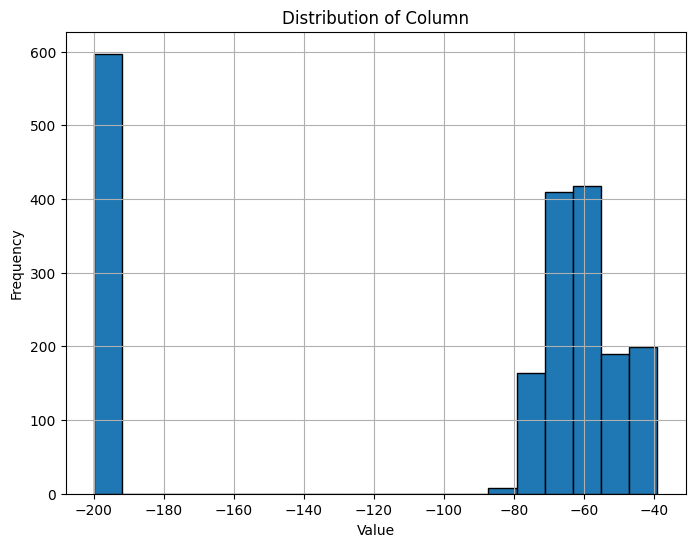

In [11]:
import matplotlib.pyplot as plt

df['rssi_ap_digilab'].hist(bins=20, edgecolor='black', figsize=(8, 6))
plt.title('Distribution of Column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [8]:
# Filter data for AP Dosen only
df_dosen = df[df['rssi_ap_dosen'].notnull()].copy()

# Function to compute d0 and RSSI_d0 for AP Dosen
def compute_reference_values(data, rssi_column):
    reference_values = data.loc[data['distance'].idxmin()]  # Find row with minimum distance
    return {
        'bssid': reference_values['bssid'],
        'd0': reference_values['distance'],
        'RSSI_d0': reference_values[rssi_column]
    }

# Compute d0 and RSSI_d0 for AP Dosen
dosen_values = compute_reference_values(df_dosen, 'rssi_ap_dosen')

# Ensure RSSI_d0 is not -200 (replace with appropriate logic if needed)
if dosen_values['RSSI_d0'] == -200:
    dosen_values['RSSI_d0'] = df_dosen[df_dosen['distance'] > dosen_values['d0']]['rssi_ap_dosen'].max()

# Display the reference values for AP Dosen
print("Reference Values for AP Dosen:")
print(f"d0 (Reference Distance): {dosen_values['d0']} meters")
print(f"RSSI_d0 (RSSI at d0): {dosen_values['RSSI_d0']} dB\n")

# Function to calculate path loss using the log-distance path loss model
def path_loss_model_log_distance(distance, d0, RSSI_d0, n=3):
    """
    Compute path loss using the log-distance path loss model.
    """
    if (distance == 0).any():
        return RSSI_d0  # Handle the case where distance is zero (ideal condition)
    return RSSI_d0 - 10 * n * np.log10(distance / d0)

# Function to calculate error metrics
def compute_error_metrics(y_true, y_pred):
    """
    Compute error metrics for evaluating model performance.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Generate a grid for visualization
x_vals = np.linspace(0, 3000, 100)
y_vals = np.linspace(0, 1500, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# AP Dosen's coordinates and dynamically computed d0 and RSSI_d0
ap_dosen_coordinates = {
    'x': 2314,
    'y': 468,
    'd0': dosen_values['d0'],
    'RSSI_d0': dosen_values['RSSI_d0']
}

# Compute the path loss grid for AP Dosen
distance_dosen = np.sqrt((X - ap_dosen_coordinates['x'])**2 + (Y - ap_dosen_coordinates['y'])**2)
distance_dosen[distance_dosen == 0] = 1e-6  # Avoid division by zero

path_loss_grid_dosen = path_loss_model_log_distance(
    distance_dosen, 
    ap_dosen_coordinates['d0'], 
    ap_dosen_coordinates['RSSI_d0']
)

# Placeholder for true observed path loss data for evaluation
true_path_loss_grid_dosen = np.random.uniform(-100, -60, size=X.shape)  # Replace with real data

# Compute error metrics for AP Dosen
mae_dosen, mse_dosen, rmse_dosen, r2_dosen = compute_error_metrics(true_path_loss_grid_dosen, path_loss_grid_dosen)

# Print error metrics
print("Error metrics for AP Dosen:")
print(f"Mean Absolute Error (MAE): {mae_dosen}")
print(f"Mean Squared Error (MSE): {mse_dosen}")
print(f"Root Mean Squared Error (RMSE): {rmse_dosen}\n")
print(f"R^2 Score: {r2_dosen}")


# Plot the heatmap for AP Dosen
plt.figure(figsize=(9, 7))
cax = plt.imshow(path_loss_grid_dosen, extent=(0, 3000, 0, 1500), origin='lower', cmap='viridis')
plt.scatter(ap_dosen_coordinates['x'], ap_dosen_coordinates['y'], color='blue', label='AP Dosen', marker='o')
plt.title('Path Loss Visualization (AP Dosen)')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.legend()
plt.colorbar(cax, label='Path Loss (dB)')
plt.tight_layout()
plt.show()


Reference Values for AP Dosen:
d0 (Reference Distance): 143.39107364128355 meters
RSSI_d0 (RSSI at d0): -62.0 dB



NameError: name 'mean_absolute_error' is not defined

Reference Values for AP Digilab:
d0 (Reference Distance): 143.39107364128355 meters
RSSI_d0 (RSSI at d0): -46.0 dB

Error metrics for AP Digilab:
Mean Absolute Error (MAE): 13.984800124147217
Mean Squared Error (MSE): 302.28680004550625
Root Mean Squared Error (RMSE): 17.38639698285721

R^2 Score: -1.3286842443082565


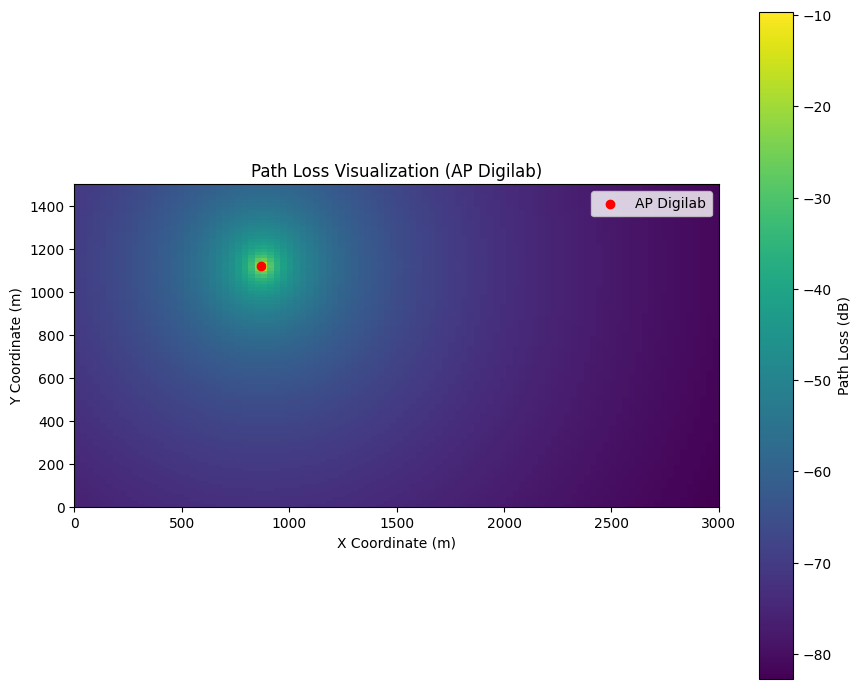

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Filter data for AP Digilab only
df_digilab = df[df['rssi_ap_digilab'].notnull()].copy()

# Function to compute d0 and RSSI_d0 for AP Digilab
def compute_reference_values(data, rssi_column):
    reference_values = data.loc[data['distance'].idxmin()]  # Find row with minimum distance
    return {
        'bssid': reference_values['bssid'],
        'd0': reference_values['distance'],
        'RSSI_d0': reference_values[rssi_column]
    }

# Compute d0 and RSSI_d0 for AP Digilab
digilab_values = compute_reference_values(df_digilab, 'rssi_ap_digilab')

# Display the reference values for AP Digilab
print("Reference Values for AP Digilab:")
print(f"d0 (Reference Distance): {digilab_values['d0']} meters")
print(f"RSSI_d0 (RSSI at d0): {digilab_values['RSSI_d0']} dB\n")

# Function to calculate path loss using the log-distance path loss model
def path_loss_model_log_distance(distance, d0, RSSI_d0, n=3):
    """
    Compute path loss using the log-distance path loss model.
    """
    if (distance == 0).any():
        return RSSI_d0  # Handle the case where distance is zero (ideal condition)
    return RSSI_d0 - 10 * n * np.log10(distance / d0)

# Function to calculate error metrics
def compute_error_metrics(y_true, y_pred):
    """
    Compute error metrics for evaluating model performance.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Generate a grid for visualization
x_vals = np.linspace(0, 3000, 100)
y_vals = np.linspace(0, 1500, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# AP Digilab's coordinates and dynamically computed d0 and RSSI_d0
ap_digilab_coordinates = {
    'x': 870,
    'y': 1122,
    'd0': digilab_values['d0'],
    'RSSI_d0': digilab_values['RSSI_d0']
}

# Compute the path loss grid for AP Digilab
distance_digilab = np.sqrt((X - ap_digilab_coordinates['x'])**2 + (Y - ap_digilab_coordinates['y'])**2)
distance_digilab[distance_digilab == 0] = 1e-6  # Avoid division by zero

path_loss_grid_digilab = path_loss_model_log_distance(
    distance_digilab, 
    ap_digilab_coordinates['d0'], 
    ap_digilab_coordinates['RSSI_d0']
)

# Placeholder for true observed path loss data for evaluation
true_path_loss_grid_digilab = np.random.uniform(-100, -60, size=X.shape)  # Replace with real data

# Compute error metrics for AP Digilab
mae_digilab, mse_digilab, rmse_digilab, r2_digilab = compute_error_metrics(true_path_loss_grid_digilab, path_loss_grid_digilab)

# Print error metrics
print("Error metrics for AP Digilab:")
print(f"Mean Absolute Error (MAE): {mae_digilab}")
print(f"Mean Squared Error (MSE): {mse_digilab}")
print(f"Root Mean Squared Error (RMSE): {rmse_digilab}\n")
print(f"R^2 Score: {r2_digilab}")


# Plot the heatmap for AP Digilab
plt.figure(figsize=(9, 7))
cax = plt.imshow(path_loss_grid_digilab, extent=(0, 3000, 0, 1500), origin='lower', cmap='viridis')
plt.scatter(ap_digilab_coordinates['x'], ap_digilab_coordinates['y'], color='red', label='AP Digilab', marker='o')
plt.title('Path Loss Visualization (AP Digilab)')
plt.xlabel('X Coordinate (m)')
plt.ylabel('Y Coordinate (m)')
plt.legend()
plt.colorbar(cax, label='Path Loss (dB)')
plt.tight_layout()
plt.show()
